# Clean Data

This notebook will clean the dataset by removing zero values and NaNs from each band.

---

## 1. Load packages and open datasets

In [73]:
%load_ext autoreload
%autoreload 2
import os
import dask
import panel
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import nisardev as nisar
import grimpfunc as grimp
import numpy as np
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)  # Avoid problems with too many open connections at NSIDC
panel.extension() 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
ziVelSeries = xr.open_dataset('../data/raw/ZachariaeIsstromVelocitySeries.nc')

In [75]:
ziVelSeries

<xarray.Dataset> Size: 482MB
Dimensions:         (time: 443, band: 3, x: 301, y: 301)
Coordinates:
  * time            (time) datetime64[ns] 4kB 2015-01-06T12:00:00 ... 2024-04...
    id              (time) <U115 204kB ...
  * band            (band) <U2 24B 'vx' 'vy' 'vv'
  * x               (x) float64 2kB 4.4e+05 4.402e+05 ... 4.998e+05 5e+05
  * y               (y) float64 2kB -1.08e+06 -1.08e+06 ... -1.14e+06 -1.14e+06
    epsg            int64 8B ...
    name            <U4 16B ...
    time1           (time) datetime64[ns] 4kB ...
    time2           (time) datetime64[ns] 4kB ...
    _FillValue      float64 8B ...
Data variables:
    spatial_ref     int64 8B ...
    VelocitySeries  (time, band, y, x) float32 482MB ...

## 2. Plot the vv band

The vv band contains the velocity values.

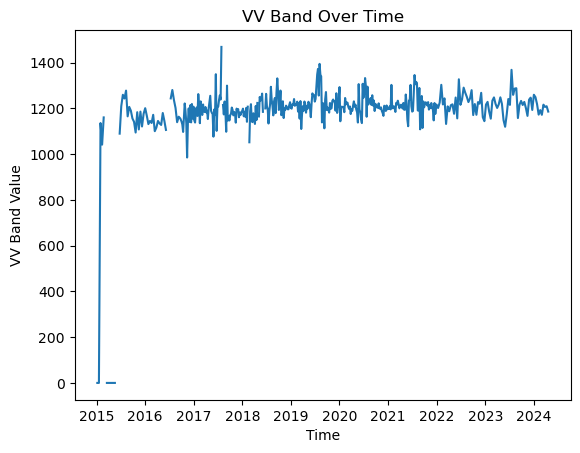

In [76]:
plt.title('VV Band Over Time')
plt.xlabel('Time')
vv_band = ziVelSeries.sel(band='vv')
vv_band['VelocitySeries'][:, 0, 0].plot()
plt.title('VV Band Over Time')
plt.xlabel('Time')
plt.ylabel('VV Band Value')
plt.show()
plt.show()

## 3. Remove NaNs and zeroes from the dataset
Remove NaNs and zeroes from all bands in case all need to be used then add them back into the dataset.

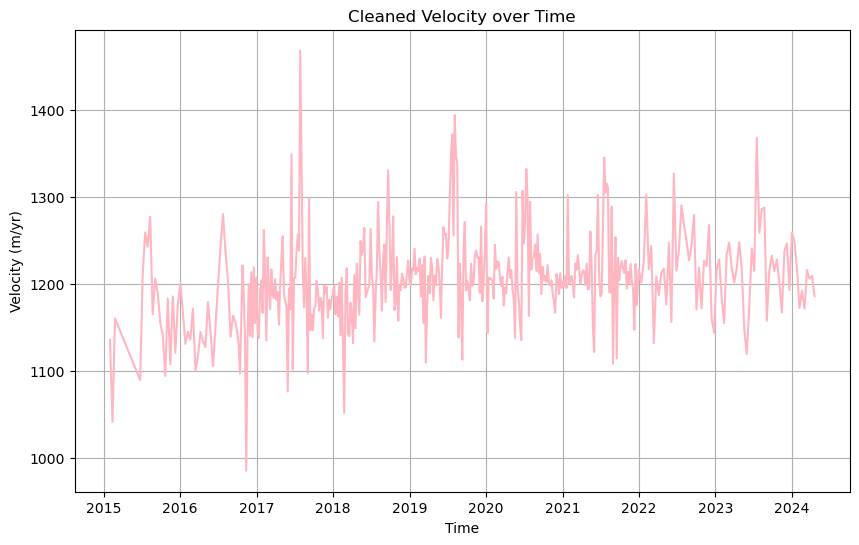

In [135]:
# Drop NaNs from the array and corresponding time values
mask = ~np.isnan(vv_band['VelocitySeries'][:,0,0]) & (vv_band['VelocitySeries'][:,0,0] != 0)
cleaned_velocity = vv_band['VelocitySeries'][:,0,0][mask]
cleaned_time = ziVelSeries.time.values[mask]

plt.figure(figsize=(10, 6))
plt.plot(cleaned_time, cleaned_velocity, color='lightpink')
plt.xlabel('Time')
plt.ylabel('Velocity (m/yr)')
plt.title('Cleaned Velocity over Time')
plt.grid(True)
plt.show()

In [139]:
# Create a new xarray dataset with the cleaned time and velocity values
cleaned_dataset = xr.Dataset(
    {
        "cleaned_velocity": (["time"], cleaned_velocity.values)
    },
    coords={
        "time": cleaned_time,
        "x": vv_band.x,
        "y": vv_band.y
    }
)

# Display the dataset
cleaned_dataset

<xarray.Dataset> Size: 10kB
Dimensions:           (time: 425, x: 301, y: 301)
Coordinates:
    band              <U2 8B 'vv'
  * x                 (x) float64 2kB 4.4e+05 4.402e+05 ... 4.998e+05 5e+05
    epsg              int64 8B 3413
    name              <U4 16B 'temp'
    _FillValue        float64 8B -1.0
  * y                 (y) float64 2kB -1.08e+06 -1.08e+06 ... -1.14e+06
  * time              (time) datetime64[ns] 3kB 2015-01-30T12:00:00 ... 2024-...
Data variables:
    cleaned_velocity  (time) float32 2kB 1.136e+03 1.041e+03 ... 1.186e+03

## 4. Save to NetCDF

In [140]:
cleaned_dataset.to_netcdf('../data/clean/Filtered_ZachariaeIsstromVelocitySeries.nc')